In [55]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
from matplotlib import pyplot as plt
from glob import glob
from os import path

In [18]:
import os
mat_dme = os.path.join('../../../data/raw/dme/Subject_01.mat')

In [19]:
from scipy.io import loadmat
mat = loadmat(mat_dme)

In [20]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

Format of mat:
images: 496x768x61
manualLayers1 and automaticLayersDME: 8x768x61
manualFluid1 and automaticFluidDME: 496x768x61

In [21]:
import numpy as np
for f in ['manualFluid1', 'manualFluid2', 'automaticFluidDME']:
    m = mat[f]
    s = np.nansum(m, axis=(0,1))
    print(np.where(s!=0))
    print(np.unique(m))

(array([10, 15, 20, 25, 28, 30, 32, 35, 40]),)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. nan]
(array([10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]),)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 24. nan]
(array([10, 15, 20, 25, 28, 30, 32, 35, 40]),)
[ 0.  1. nan]


In [17]:
import numpy as np
for f in ['manualLayers1', 'manualLayers2', 'automaticLayersDME', 'automaticLayersNormal']:
    m = mat[f]
    s = np.nansum(m, axis=(0,1))
    print(np.where(s!=0))
    print(np.unique(m))

(array([10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]),)
[ 76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187.
 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201.
 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215.
 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229.
 230. 231.  nan]
(array([10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]),)
[ 77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94. 

In [8]:
np.where(s != 0)

(array([131, 131, 131, ..., 195, 195, 195]),
 array([136, 137, 138, ..., 476, 477, 478]))

In [42]:
fluid_class = 9

In [43]:
#get the valid masks:
def get_valid_idx(layerMap):
    idx = []
    for i in range(0,61):
        temp = layerMap[:,:,i]
        if np.sum(temp) != 0:
            idx.append(i)
    return idx

In [44]:
layerMaps = np.array(mat['manualLayers1'], dtype=np.uint16)
img = np.array(mat['images'], dtype=np.uint8)
valid_idx = get_valid_idx(layerMaps)

layerMaps = layerMaps[:,:,valid_idx]

print(layerMaps.shape)

(8, 768, 11)


C:\Users\phili\AppData\Local\Temp\ipykernel_9756\1195446695.py:1: RuntimeWarning: invalid value encountered in cast
  layerMaps = np.array(mat['manualLayers1'], dtype=np.uint16)


In [45]:
def get_valid_img_seg(mat):
    layerMaps = np.array(mat['manualLayers2'], dtype=np.uint16)
    img = np.array(mat['images'], dtype=np.uint8)
    valid_idx = get_valid_idx(layerMaps)

    layerMaps = layerMaps[:, :, valid_idx]

    seg = np.zeros((496, 768, 11))
    max_col = -100
    min_col = 1100
    for idx in range(0, 11):
        for col in range(768):
            cur_col = layerMaps[:, col, idx]
            if np.sum(cur_col) == 0:
                continue

            max_col = max(max_col, col)
            min_col = min(min_col, col)

            labels_idx = cur_col.tolist()
            last_st = None
            last_ed = None
            for label, (st, ed) in enumerate(zip([0]+labels_idx, labels_idx+[-1])):

                #seg[st:ed, col, idx] = label
                if st == 0 and ed == 0:
                    st = last_ed

                if ed == 0:
                    ed = st + 1

                if st == 0 and label != 0:
                    st = ed-1
                    st += 1

                seg[st:ed, col, idx] = label
                last_st = st
                last_ed = ed

    seg = seg[:, min_col:max_col+1]
    img = img[:, min_col:max_col+1]
    return img, seg

In [46]:

def get_valid_img_seg(mat):
    manualLayer = np.array(mat['manualLayers1'], dtype=np.uint16)
    manualFluid = np.array(mat['manualFluid1'], dtype=np.uint16)
    img = np.array(mat['images'], dtype=np.uint8)
    valid_idx = get_valid_idx(manualLayer)


    manualFluid = manualFluid[:, :, valid_idx]
    manualLayer = manualLayer[:, :, valid_idx]

    print(manualLayer.shape)

    seg = np.zeros((496, 768, 11))
    seg[manualFluid > 0] = fluid_class
    max_col = -100
    min_col = 900
    for b_scan_idx in range(0, 11):
        for col in range(768):
            cur_col = manualLayer[:, col, b_scan_idx]
            if np.sum(cur_col) == 0:
                continue

            max_col = max(max_col, col)
            min_col = min(min_col, col)

            labels_idx = cur_col.tolist()
            #         print(f'{b_scan_idx} {labels_idx}')
            #         labels_idx.append(-1)
            #         labels_idx.insert(0, 0)
            last_st = None
            last_ed = None
            for label, (st, ed) in enumerate(zip([0]+labels_idx, labels_idx+[-1])):
                #             print(st, ed)
                if st == 0 and ed == 0:
                    st = last_ed
                    # 穿越第一层
                    while(seg[st, col, b_scan_idx] == fluid_class):
                        st += 1

                    while(seg[st, col, b_scan_idx] != fluid_class):
                        seg[st, col, b_scan_idx] = label
                        st += 1
                        if st >= 496:
                            break
                    continue
                if ed == 0:
                    ed = st + 1
                    while(seg[ed, col, b_scan_idx] != fluid_class):
                        ed += 1

                if st == 0 and label != 0:
                    st = ed-1
                    while(seg[st, col, b_scan_idx] != fluid_class):
                        st -= 1
                    st += 1

                seg[st:ed, col, b_scan_idx] = label
                last_st = st
                last_ed = ed

    seg[manualFluid > 0] = fluid_class

    seg = seg[:, min_col:max_col+1]
    img = img[:, min_col:max_col+1]
    return img, seg

In [47]:
img, seg = get_valid_img_seg(mat)

C:\Users\phili\AppData\Local\Temp\ipykernel_9756\2686145428.py:2: RuntimeWarning: invalid value encountered in cast
  manualLayer = np.array(mat['manualLayers1'], dtype=np.uint16)
C:\Users\phili\AppData\Local\Temp\ipykernel_9756\2686145428.py:3: RuntimeWarning: invalid value encountered in cast
  manualFluid = np.array(mat['manualFluid1'], dtype=np.uint16)


(8, 768, 11)


In [ ]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in range(len(colors)):
    h = colors[i].lstrip('#')
    colors[i] = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for cl, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = colors[cl][i] / 255
        ax.imshow(np.dstack((img, m * 0.35)))

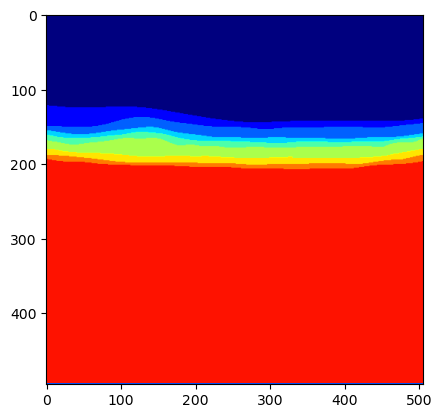

In [53]:
plt.imshow(img[:, :, 0])
plt.imshow(seg[:, :, 0], cmap=plt.cm.jet, vmax=9)

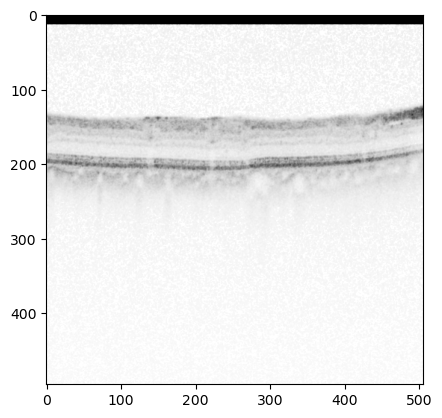

In [49]:
plt.imshow(img[:, :, 0], cmap="Greys", vmin=0, vmax=255)

In [50]:
original_img = mat['images']

In [51]:
img

array([[[255, 255, 255, ...,  22,  35,  12],
        [255, 255, 255, ...,  21,  21,  38],
        [255, 255, 255, ...,  41,   0,  33],
        ...,
        [255, 255, 255, ..., 255,  40,   0],
        [255, 255, 255, ..., 255,  36,  29],
        [255, 255, 255, ..., 255,  41,  31]],

       [[255, 255, 255, ...,  32,  38,  29],
        [255, 255, 255, ...,  35,  24,  43],
        [255, 255, 255, ...,  45,   0,  40],
        ...,
        [255, 255, 255, ..., 255,  22,  17],
        [255, 255, 255, ..., 255,  23,  40],
        [255, 255, 255, ..., 255,  37,  25]],

       [[255, 255, 255, ...,  22,  24,  43],
        [255, 255, 255, ...,  36,  25,  45],
        [255, 255, 255, ...,  33,  32,  40],
        ...,
        [255, 255, 255, ..., 255,  30,  26],
        [255, 255, 255, ..., 255,  12,  23],
        [255, 255, 255, ..., 255,  27,  14]],

       ...,

       [[  0,  15,  14, ..., 255, 255, 255],
        [  0,  14,   0, ..., 255, 255, 255],
        [  0,  14,   4, ..., 255, 255, 255

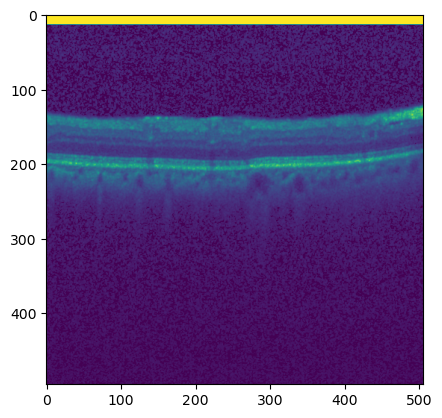

In [52]:
plt.imshow(img[:,:,0])

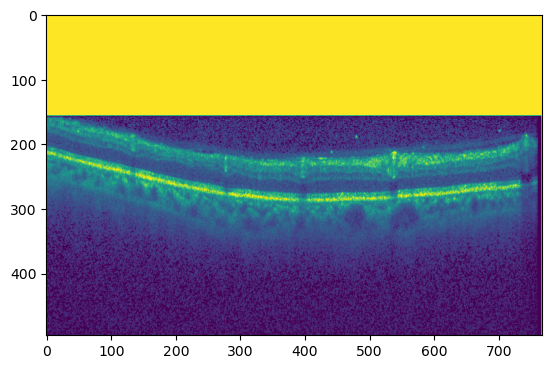

In [37]:
plt.imshow(original_img[:,:,0])